In [ ]:
#Importing Libraries
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
import os
#Loading the list of chopin's midi files as stream
filepath = "D:\\FYP\\MIDI_Data\\adl-piano-midi\\Classical\\Classical\\Wolfgang Amadeus Mozart"

# Getting midi files
all_midis = []

for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = os.path.join(filepath, i)  # Use os.path.join for path concatenation to avoid any issues
        midi = converter.parse(tr)
        all_midis.append(midi)

In [ ]:
print(len(all_midis))

110


In [ ]:
#Helping function
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Mozart midis in the dataset:", len(Corpus))

Total notes in all the Mozart midis in the dataset: 53765


In [ ]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['D5', '7.11', 'G3', 'G5', 'D3', 'A5', 'G3', 'G5', 'F#5', 'G5', 'A5', 'F#3', 'A5', 'D3', 'B5', 'F#3', 'A5', 'G5', 'A5', 'B5', 'G3', '7.11.2', 'D3', '0.2.6', 'A3', '9.2', 'F#3', 'D3', 'D5', 'A5', 'F#3', 'A5', 'D3', 'B5', 'F#3', 'A5', 'G5', 'A5', 'B5', 'G3', 'B5', 'D3', 'C6', 'G3', 'B5', 'A5', 'B5', 'C6', 'A3', 'A5']


In [ ]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))

def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])

In [ ]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 266


In [ ]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 202.12406015037595
Most frequent note in Corpus appeared: 2641 times
Least frequent note in Corpus appeared: 1 time


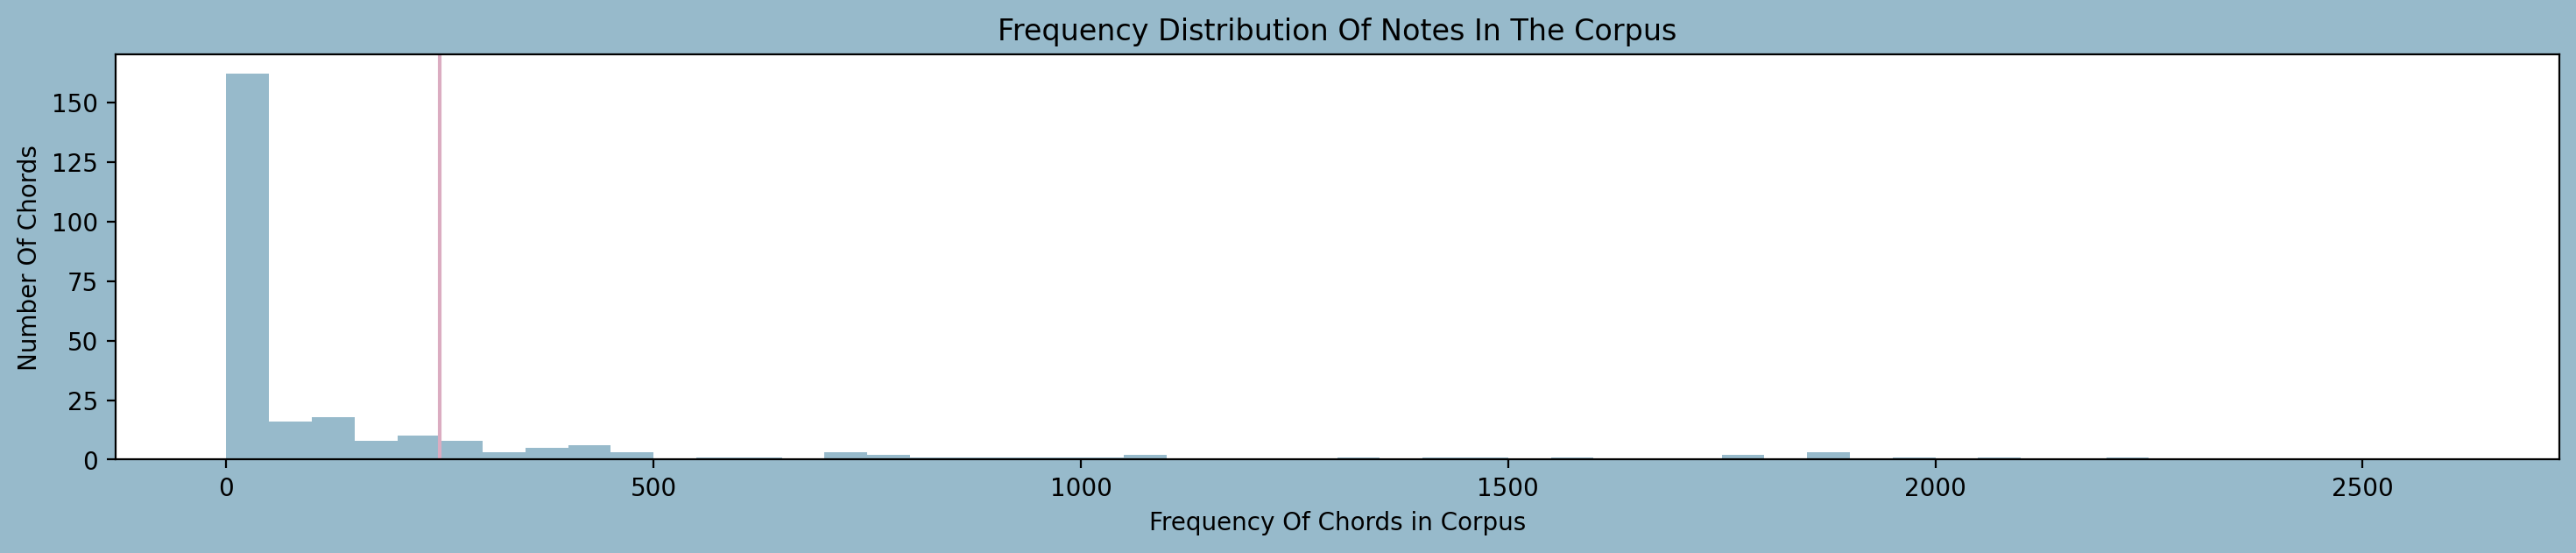

In [ ]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=250,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [ ]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 500:
        m =  key
        rare_note.append(m)

print("Total number of notes that occur less than 500 times:", len(rare_note))

Total number of notes that occur less than 100 times: 239


In [ ]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 41157


In [ ]:
# Storing all the unique characters present in my corpus to bult a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus# predictio
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 41157
Number of unique characters: 219


In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 41117


In [ ]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [ ]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
#Model's Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 219)               56283     
                                                                 
Total params: 1962203 (7.49 MB)
Trainable params: 196220

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('test_model.h5', monitor='loss', save_best_only=True, verbose=1)

In [ ]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=200, callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
129/129 [==============================] - ETA: 0s - loss: 3.9007
Epoch 1: loss improved from inf to 3.90071, saving model to test_model.h5
129/129 [==============================] - 98s 731ms/step - loss: 3.9007
Epoch 2/200
129/129 [==============================] - ETA: 0s - loss: 3.8114
Epoch 2: loss improved from 3.90071 to 3.81144, saving model to test_model.h5
129/129 [==============================] - 97s 754ms/step - loss: 3.8114
Epoch 3/200
129/129 [==============================] - ETA: 0s - loss: 3.8089
Epoch 3: loss improved from 3.81144 to 3.80892, saving model to test_model.h5
129/129 [==============================] - 92s 712ms/step - loss: 3.8089
Epoch 4/200
129/129 [==============================] - ETA: 0s - loss: 3.8031
Epoch 4: loss improved from 3.80892 to 3.80309, saving model to test_model.h5
129/129 [==============================] - 91s 702ms/step - loss: 3.8031
Epoch 5/200
129/129 [==============================] - ETA: 0s - loss: 3.7664
Epoch 5: l

[Text(0.5, 0, 'Epochs')]

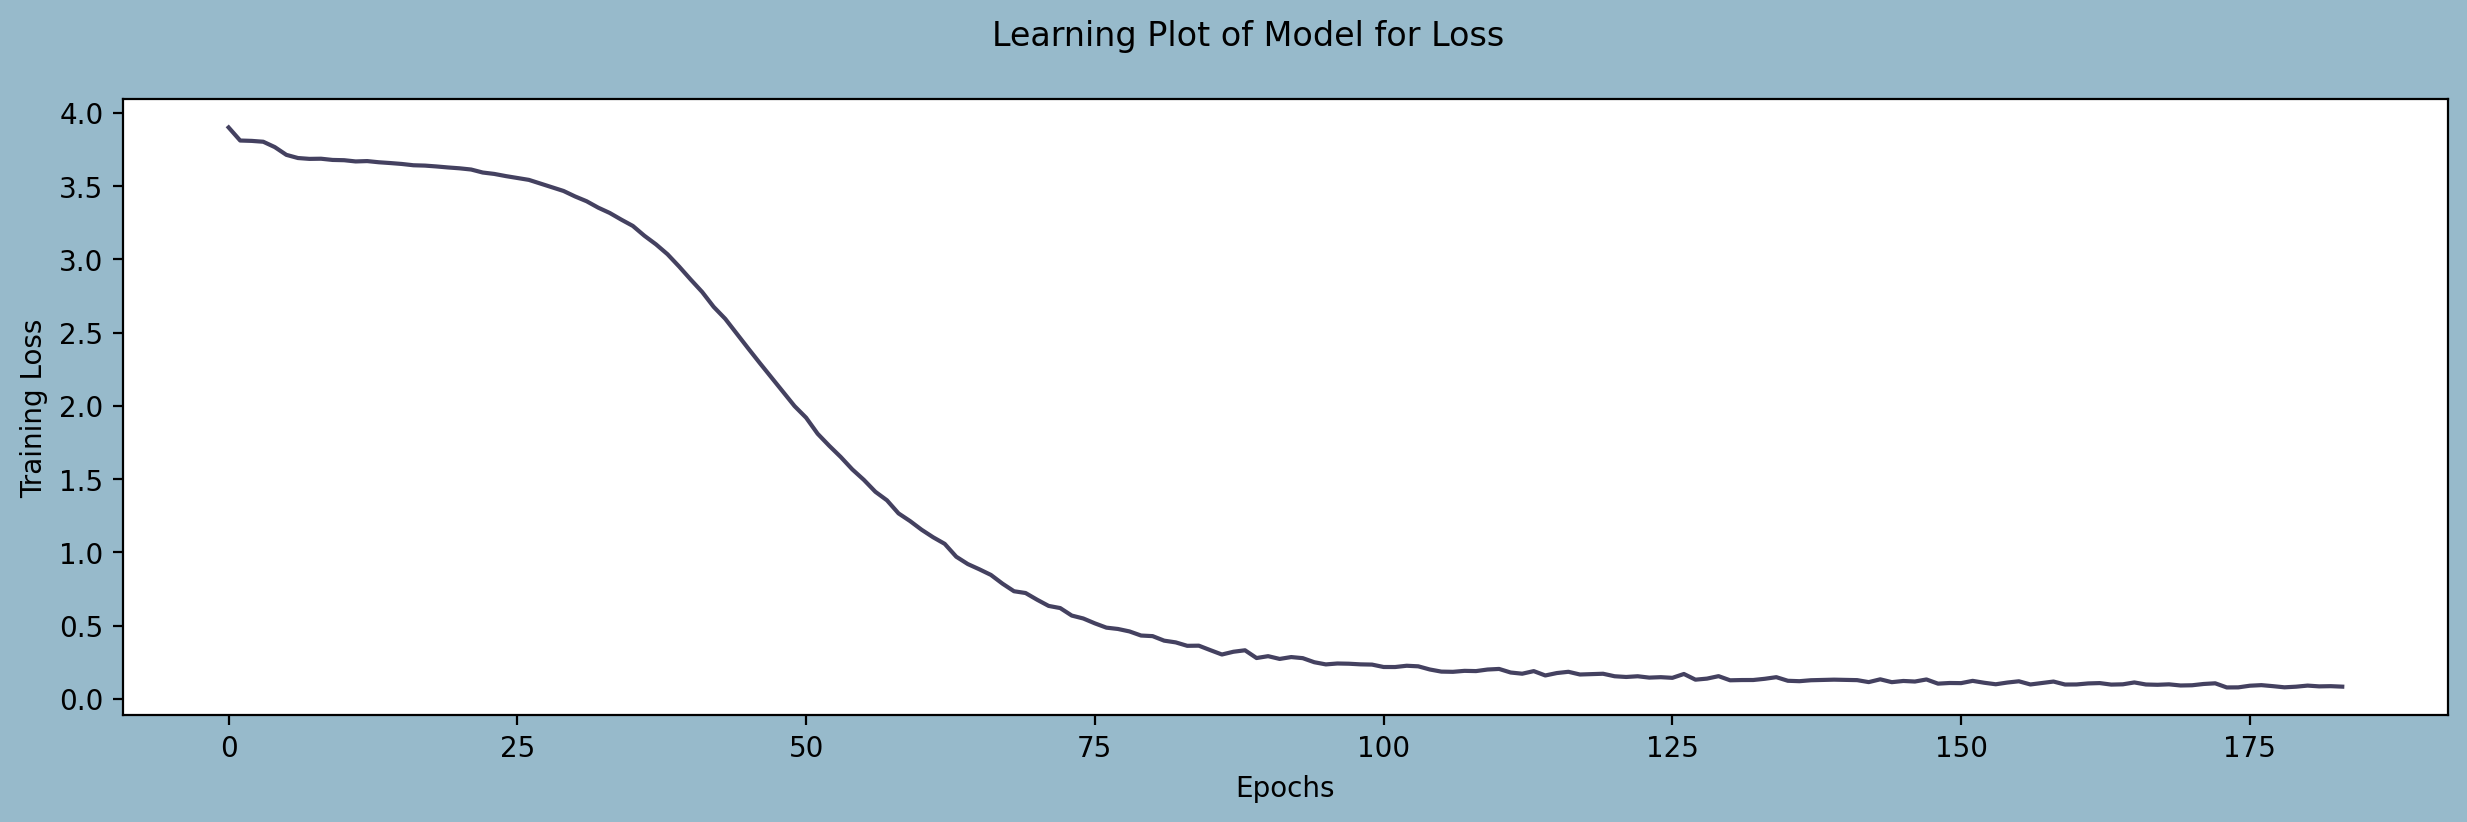

In [ ]:
#Plotting the learnings
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [ ]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        # reshapes seed to match input shape of model
        seed = seed.reshape(1,length,1)
        # predict next note based on current seed
        prediction = model.predict(seed, verbose=0)[0]
        # Apply a diversity factor to the probabilities, This helps control randomness in the generated music
        prediction = np.log(prediction) / 1.0
        #next two lines apply a softmax activation to rpedictions to convert them to probability space
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        # select index of highest probability
        index = np.argmax(prediction)
        # convert index back to original value
        index_N = index/ float(L_symb)
        # add to list
        Notes_Generated.append(index)
        # convert back to original musical representation using reverse mapping
        Music = [reverse_mapping[char] for char in Notes_Generated]
        # updates seed sequence
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(20)
#show(Melody)

In [ ]:
Melody.write('midi', fp='D:\\FYP\\Gen\\test3.mid')


'D:\\FYP\\Gen\\test3.mid'

In [ ]:
model.save('D:\FYP\Models\FirstModel')


INFO:tensorflow:Assets written to: D:\FYP\Models\FirstModel\assets


INFO:tensorflow:Assets written to: D:\FYP\Models\FirstModel\assets
